In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pylab
import scipy.stats as stats
import scipy.interpolate as inter
import plotly.express as px
from sklearn import preprocessing as skprep
import numba
import timeit
import math
import itertools
from pprint import pprint
from mnk import MNK

In [14]:
def norm(x):
    return (x - x.min()) / (x.max() - x.min())

In [15]:
def f_test(x, y):
    x = np.array(x)
    y = np.array(y)
    f = np.var(x, ddof=1)/np.var(y, ddof=1) #calculate F test statistic
    dfn = x.size-1 #define degrees of freedom numerator
    dfd = y.size-1 #define degrees of freedom denominator
    p = 1-stats.f.cdf(f, dfn, dfd) #find p-value of F test statistic
    return f, p

In [16]:
df = pd.read_csv("DataSet1_3.csv", sep=',')
df = df.dropna()

df["Date"] = pd.to_datetime(df["Date"])
df["Date"] = norm(df["Date"].values.astype("float64"))

df = df.drop(columns=[
    'Name'
])
df = df.drop_duplicates()
df = df.reset_index(drop=True)

predict_column = "Date"

columns = list(df.columns)
columns.remove(predict_column)
columns = [predict_column] + columns
columns = pd.Index(columns)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3019 entries, 0 to 3018
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    3019 non-null   float64
 1   Open    3019 non-null   float64
 2   High    3019 non-null   float64
 3   Low     3019 non-null   float64
 4   Close   3019 non-null   float64
 5   Volume  3019 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 141.6 KB


In [17]:
df

,Date,Open,High,Low,Close,Volume
0,0.000000,211.47,218.05,209.32,217.83,13137450
1,0.000228,222.17,224.70,220.09,222.84,15292353
2,0.000457,223.22,226.00,220.97,225.85,10815661
3,0.000685,228.66,235.49,226.85,233.06,17759521
4,0.001370,233.44,236.94,230.70,233.68,12795837
...,...,...,...,...,...,...
3014,0.998401,1070.00,1071.72,1067.64,1068.86,889446
3015,0.999315,1068.64,1068.86,1058.64,1065.85,918767
3016,0.999543,1066.60,1068.27,1058.38,1060.20,1116203
3017,0.999772,1062.25,1064.84,1053.38,1055.95,994249


In [18]:
df.nunique()

Date      3019
Open      2880
High      2855
Low       2875
Close     2919
Volume    3019
dtype: int64

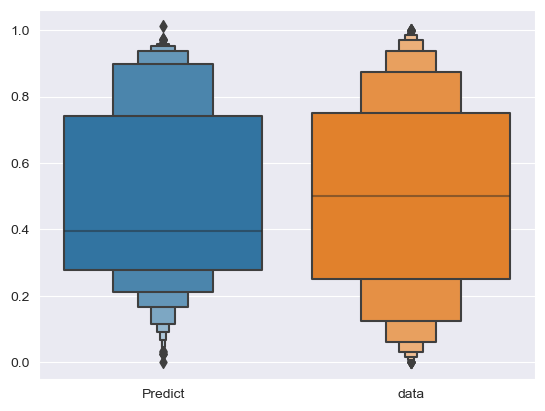

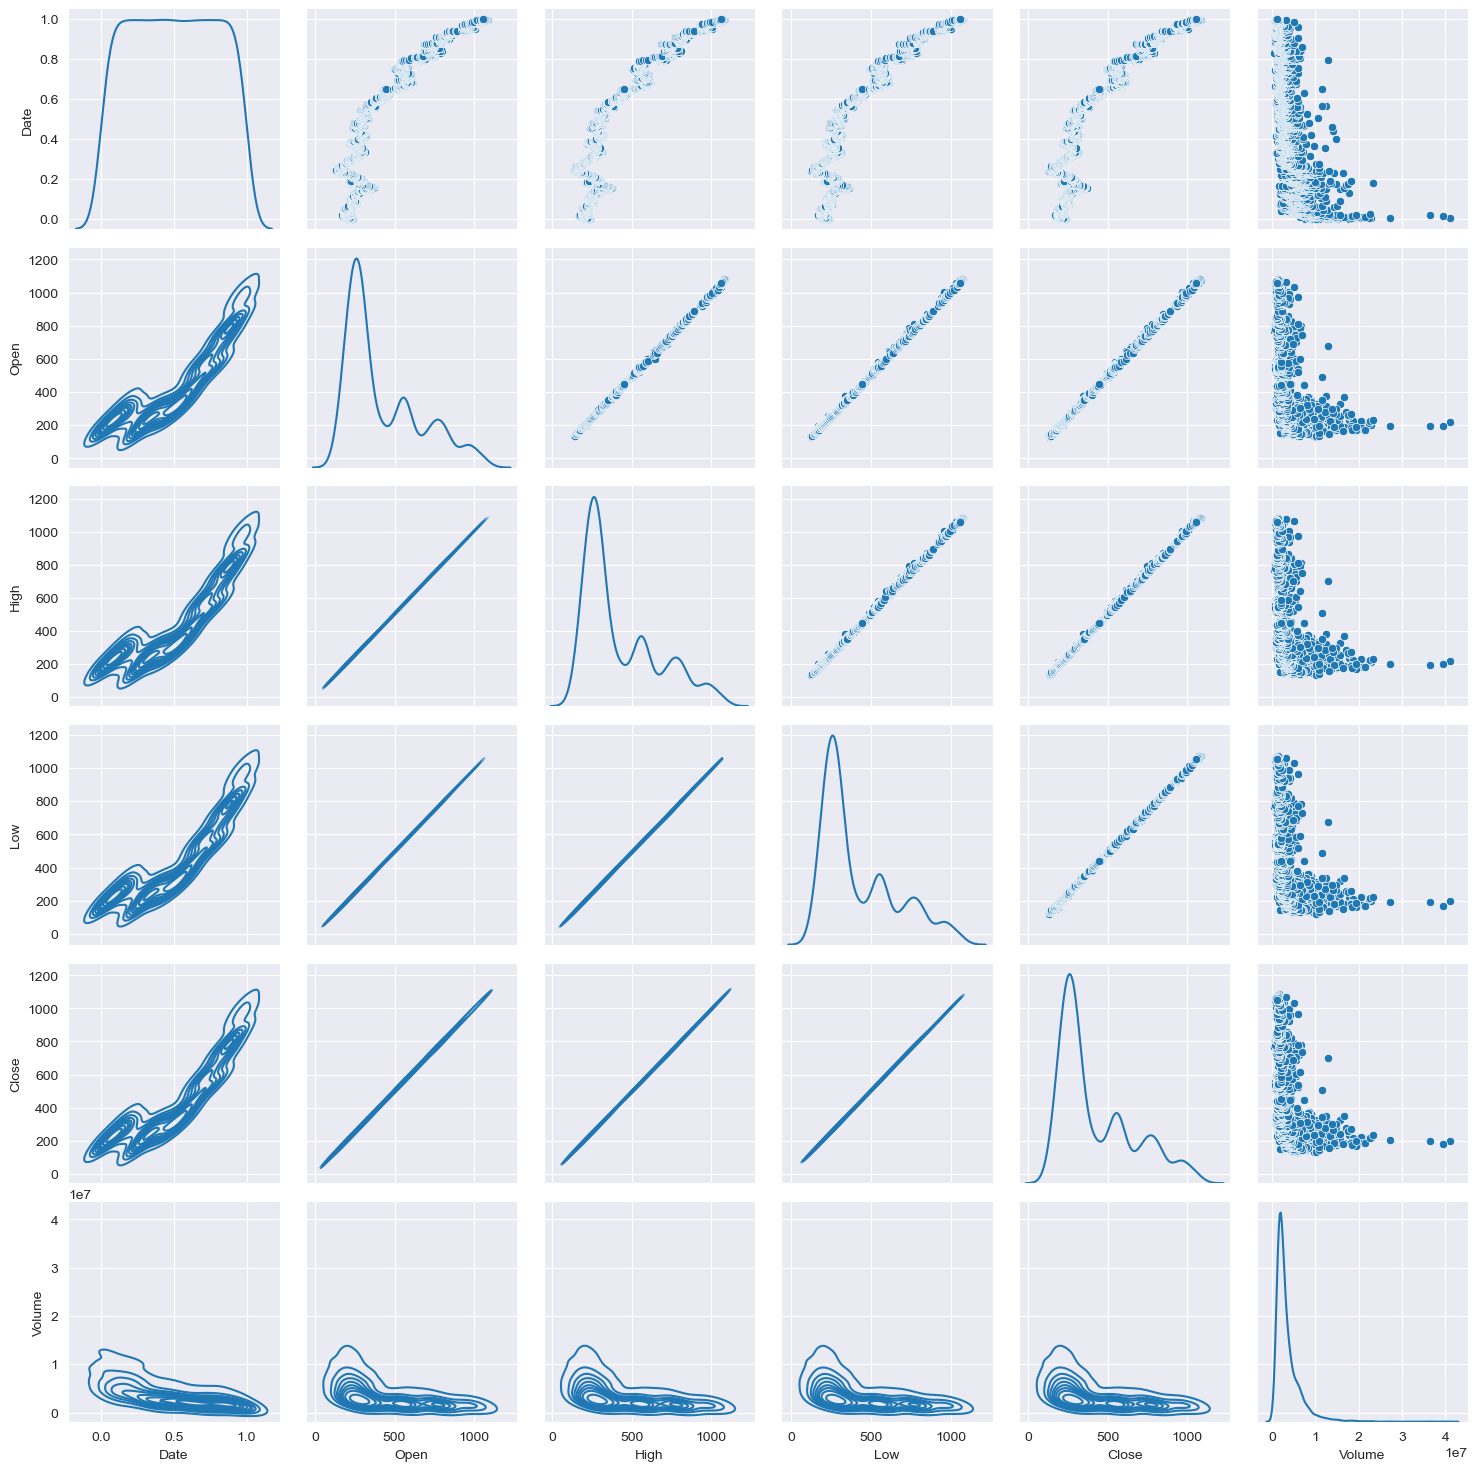

In [19]:
g = sns.PairGrid(df, diag_sharey=False)
g.map_upper(sns.scatterplot)
g.map_lower(sns.kdeplot)
g.map_diag(sns.kdeplot)
plt.show()

# Sample

In [20]:
sample = df.sample(
    # 5
    int(len(df) * 0.3)
)
sample = sample.drop_duplicates(subset=[predict_column])
indexes = df.index.delete(df.index.isin(sample.index))
sample = sample.sort_values(by=predict_column)
sample = sample.reset_index(drop=True)
X = sample.loc[0:len(sample), columns[~columns.isin([predict_column])]].to_numpy()
y = sample.loc[0:len(sample), [predict_column]].to_numpy()

In [21]:
sample

,Date,Open,High,Low,Close,Volume
0,0.000228,222.17,224.70,220.09,222.84,15292353
1,0.000685,228.66,235.49,226.85,233.06,17759521
2,0.001370,233.44,236.94,230.70,233.68,12795837
3,0.003426,223.87,228.91,221.85,222.68,20511176
4,0.003883,219.57,220.24,197.57,199.93,41182889
...,...,...,...,...,...,...
900,0.992005,1054.39,1060.07,1051.92,1056.52,825369
901,0.994290,1027.80,1031.34,1009.22,1011.87,1938861
902,0.996117,1050.00,1062.50,1044.87,1048.77,1694061
903,0.996574,1055.49,1067.08,1053.60,1057.47,1548139


# МНК

In [22]:
funcs = [
    lambda x: x[0] ** 0,
    lambda x: x[0],
    lambda x: x[0] ** 2,
    lambda x: x[1],
    lambda x: x[1] ** 2,
    lambda x: x[2],
    lambda x: x[2] ** 2,
    lambda x: x[3],
    lambda x: x[3] ** 2,
    lambda x: x[4],
    lambda x: x[4] ** 2,
    # lambda x: x[5],
    # lambda x: x[5] ** 2,
    # lambda x: x[6],
    # lambda x: x[6] ** 2,
]
# funcs[1](df.loc[:, 1:6].to_numpy().T), funcs[16](df.loc[:, 1:6].to_numpy().T)
mnk = MNK(sample.loc[:, columns[~columns.isin([predict_column])]].to_numpy().T, sample[predict_column].values, funcs)
# mnk = MNK(df.loc[:, 1:6].to_numpy().T, df[7].values, funcs)
mnk.c

array([-2.79082695e-01, -3.34170076e-03,  1.63451882e-06,  4.76262384e-03,
       -3.12775452e-06, -3.52940060e-03,  4.07364730e-06,  4.58246726e-03,
       -3.78189143e-06])

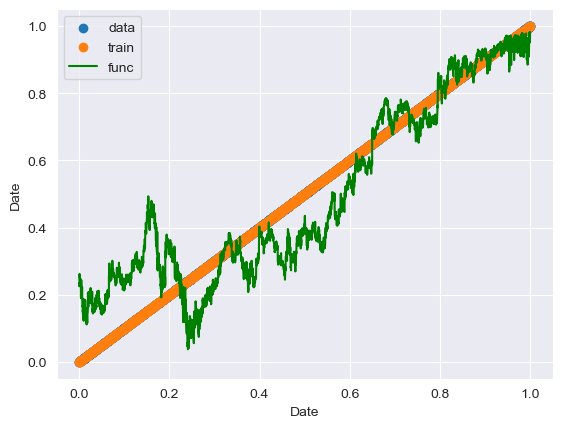

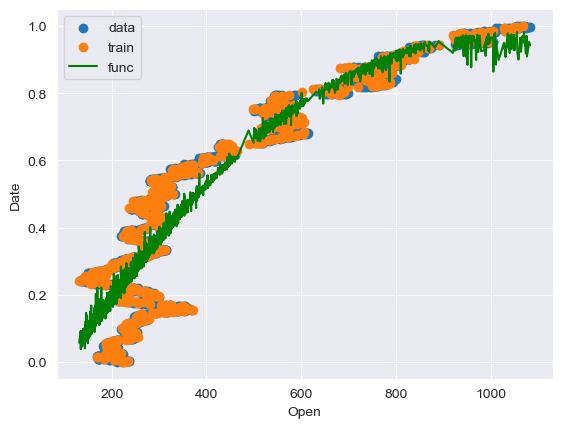

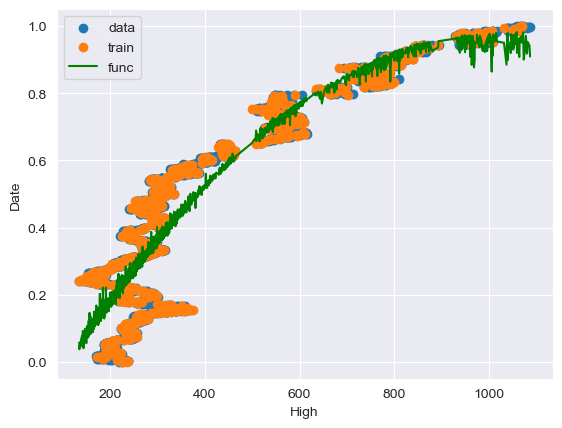

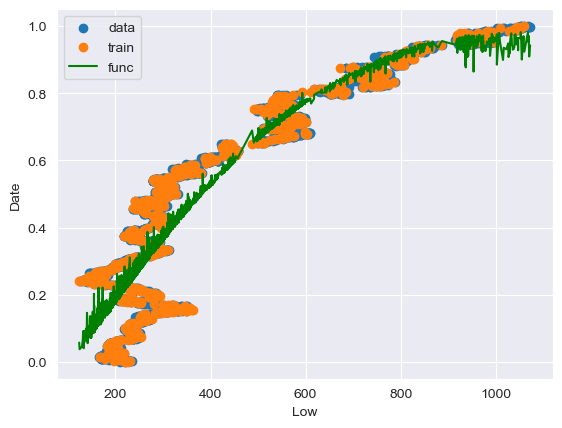

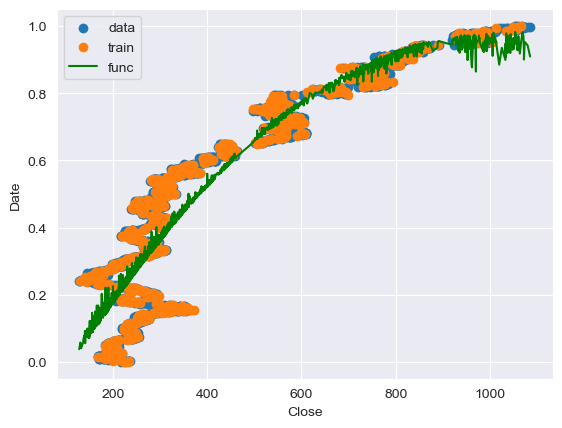

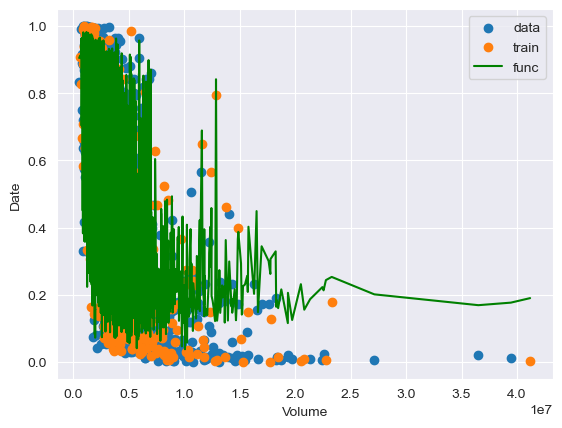

In [23]:
for i in range(len(columns)):
    # x_new = np.linspace(mnk.x.min(), mnk.x.max(), num=500,
    #                     endpoint=True)  # np.arange(x.min(), x.max(), (x.max() - x.min()) / 100)
    data = df.sort_values(by=columns[i])
    plt.scatter(df[columns[i]][indexes], df[predict_column][indexes], label='data')
    plt.scatter(sample[columns[i]], sample[predict_column], label='train')
    plt.plot(data[columns[i]], mnk(data.loc[:, columns[~columns.isin([predict_column])]].to_numpy().T), label='func', color='green')
    plt.legend(loc='best')
    plt.ylabel(predict_column)
    plt.xlabel(columns[i])
    ax = plt.gca()
    # ax.set_xlim([0, 1])
    # ax.set_ylim([0, 1])
    # pprint(mnk.c)
    plt.show()

exp_data = mnk(df.loc[:, columns[~columns.isin([predict_column])]].to_numpy().T)
exp_data = exp_data.reshape(len(exp_data))

In [24]:
sns.boxenplot(data=pd.DataFrame({"Predict":exp_data.T, "data": df[predict_column].values.T}))

<AxesSubplot:>

In [25]:
print(f"Стьюдент {stats.ttest_ind(exp_data, df[predict_column])}")
stat = f_test(exp_data, df[predict_column])
print(f"F-test   stat = {stat[0]}, pvalue = {stat[1]}")
stat = stats.chi2_contingency([np.abs(exp_data), np.abs(df[predict_column])])
print(f"X2       stat = {stat[0]}, pvalue = {stat[1]}")

Стьюдент Ttest_indResult(statistic=-0.5855978279684966, pvalue=0.5581677013116751)
F-test   stat = 0.8754572441618877, pvalue = 0.9998698282838737
X2       stat = 75.01787215045367, pvalue = 1.0


# kNN

In [26]:
from sklearn.neighbors import KNeighborsRegressor

neigh = KNeighborsRegressor(n_neighbors=5)
neigh.fit(X, y)

KNeighborsRegressor()

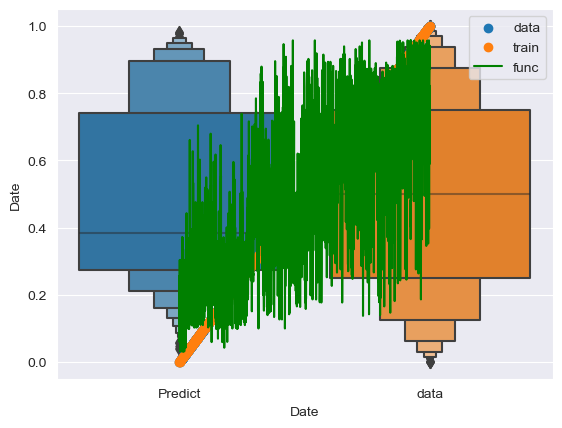

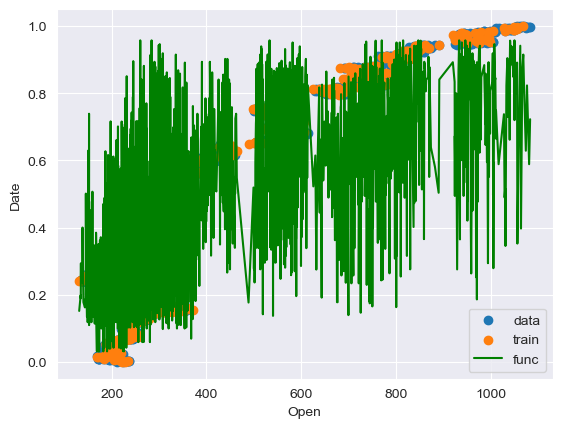

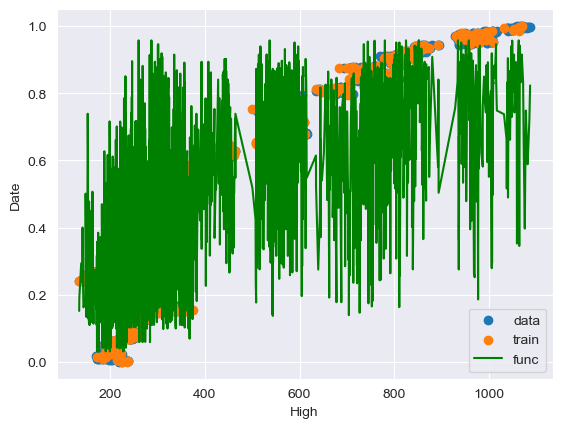

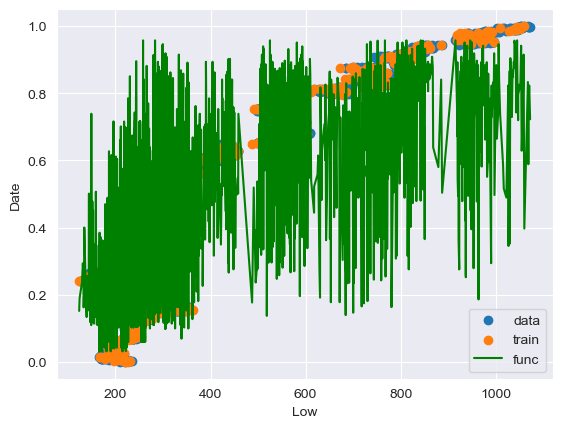

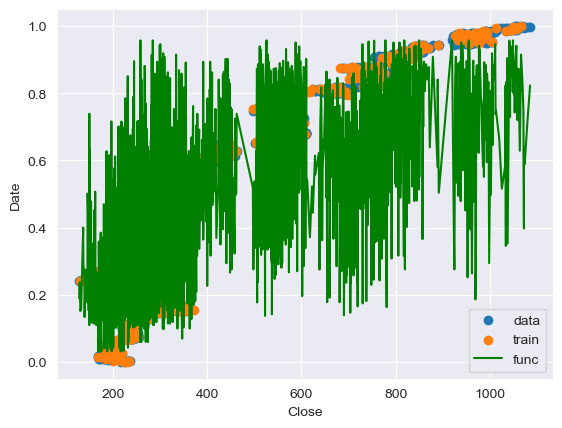

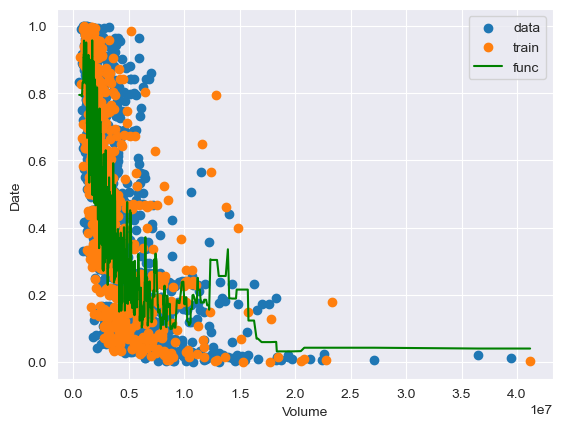

In [27]:
for i in range(len(columns)):
    # x_new = np.linspace(mnk.x.min(), mnk.x.max(), num=500,
    #                     endpoint=True)  # np.arange(x.min(), x.max(), (x.max() - x.min()) / 100)
    data = df.sort_values(by=columns[i])
    plt.scatter(df[columns[i]][indexes], df[predict_column][indexes], label='data')
    plt.scatter(sample[columns[i]], sample[predict_column], label='train')
    plt.plot(data[columns[i]], neigh.predict(data.loc[:, columns[~columns.isin([predict_column])]].to_numpy()), label='func',
             color='green')
    plt.legend(loc='best')
    plt.ylabel(predict_column)
    plt.xlabel(columns[i])
    ax = plt.gca()
    # ax.set_xlim([0, 1])
    # ax.set_ylim([0, 1])
    # pprint(mnk.c)
    plt.show()

exp_data = neigh.predict(df.loc[:, columns[~columns.isin([predict_column])]].to_numpy())
exp_data = exp_data.reshape(len(exp_data))

In [28]:
sns.boxenplot(data=pd.DataFrame({"Predict":exp_data.T, "data": df[predict_column].values.T}))

<AxesSubplot:>

In [29]:
print(f"Стьюдент {stats.ttest_ind(exp_data, df[predict_column])}")
stat = f_test(exp_data, df[predict_column])
print(f"F-test   stat = {stat[0]}, pvalue = {stat[1]}")
stat = stats.chi2_contingency([np.abs(exp_data), np.abs(df[predict_column])])
print(f"X2       stat = {stat[0]}, pvalue = {stat[1]}")

Стьюдент Ttest_indResult(statistic=-0.7042908508225388, pvalue=0.48127883335253874)
F-test   stat = 0.6594836135167778, pvalue = 1.0
X2       stat = 143.3094616503475, pvalue = 1.0


# Lasso

In [30]:
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=0.5)
lasso.fit(X, y)

Lasso(alpha=0.5)

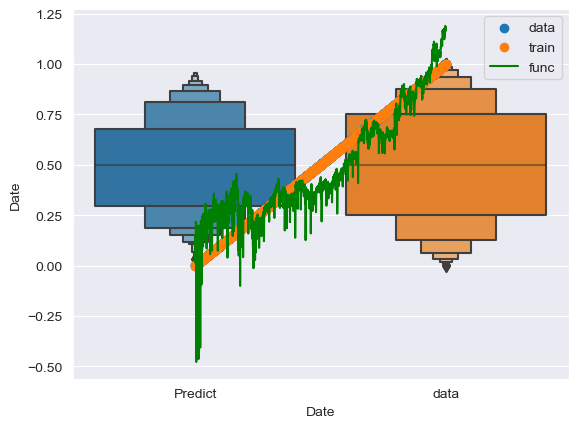

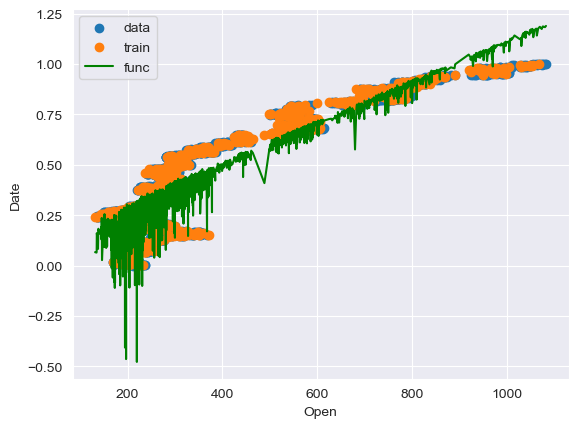

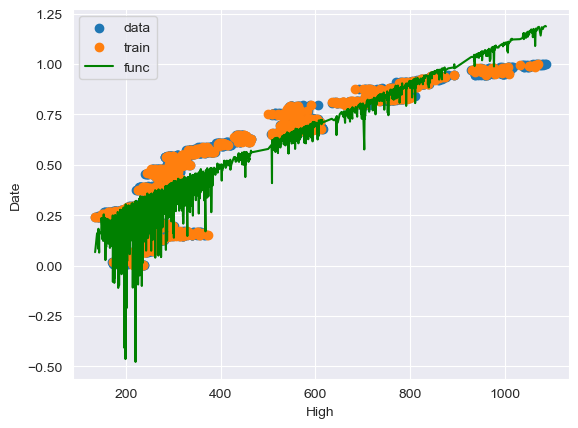

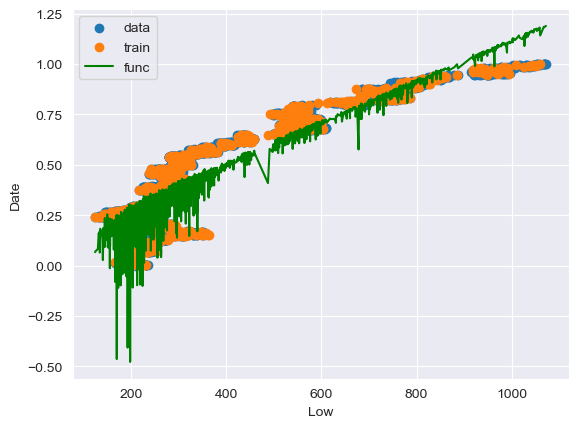

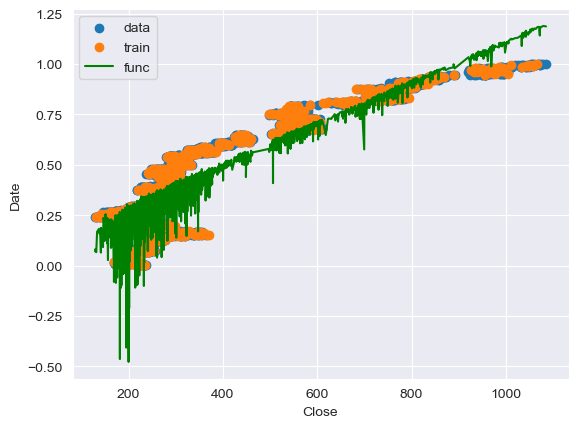

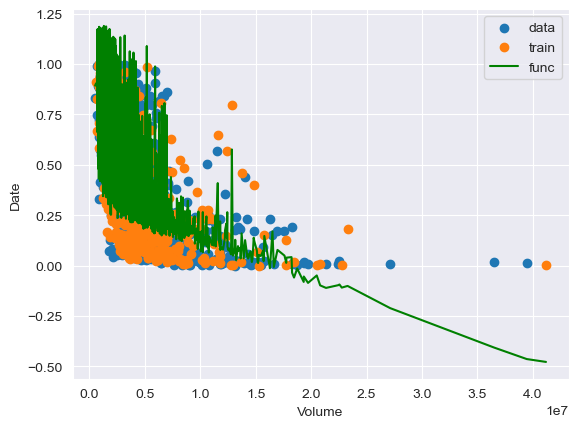

In [31]:
for i in range(len(columns)):
    # x_new = np.linspace(mnk.x.min(), mnk.x.max(), num=500,
    #                     endpoint=True)  # np.arange(x.min(), x.max(), (x.max() - x.min()) / 100)
    data = df.sort_values(by=columns[i])
    plt.scatter(df[columns[i]][indexes], df[predict_column][indexes], label='data')
    plt.scatter(sample[columns[i]], sample[predict_column], label='train')
    plt.plot(data[columns[i]], lasso.predict(data.loc[:, columns[~columns.isin([predict_column])]].to_numpy()), label='func',
             color='green')
    plt.legend(loc='best')
    plt.ylabel(predict_column)
    plt.xlabel(columns[i])
    ax = plt.gca()
    # ax.set_xlim([0, 1])
    # ax.set_ylim([0, 1])
    # pprint(mnk.c)
    plt.show()

exp_data = lasso.predict(df.loc[:, columns[~columns.isin([predict_column])]].to_numpy())

In [32]:
sns.boxenplot(data=pd.DataFrame({"Predict":mnk(df.loc[:, columns[~columns.isin([predict_column])]].to_numpy().T).T, "data": df[predict_column].values.T}))

<AxesSubplot:>

In [33]:
print(f"Стьюдент {stats.ttest_ind(exp_data, df[predict_column])}")
stat = f_test(exp_data, df[predict_column])
print(f"F-test   stat = {stat[0]}, pvalue = {stat[1]}")
stat = stats.chi2_contingency([np.abs(exp_data), np.abs(df[predict_column])])
print(f"X2       stat = {stat[0]}, pvalue = {stat[1]}")

Стьюдент Ttest_indResult(statistic=-0.4852318811241416, pvalue=0.6275294798105067)
F-test   stat = 0.8612131052362126, pvalue = 0.9999795081367193
X2       stat = 67.78091748407391, pvalue = 1.0


# Ridge

In [34]:
from sklearn.linear_model import Ridge

ridge = Ridge(alpha=0.5)
ridge.fit(X, y)

Ridge(alpha=0.5)

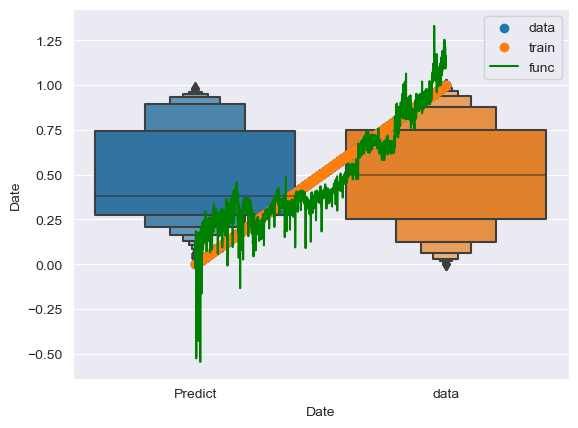

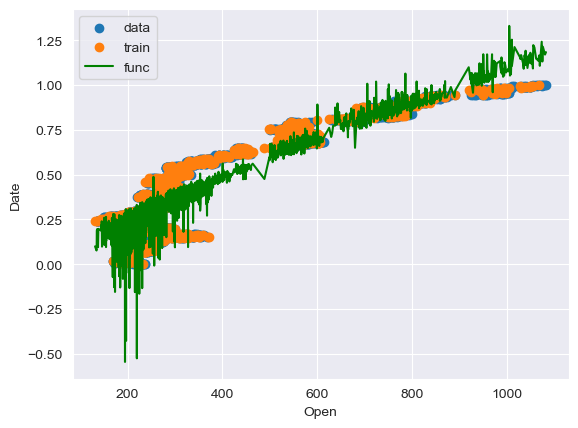

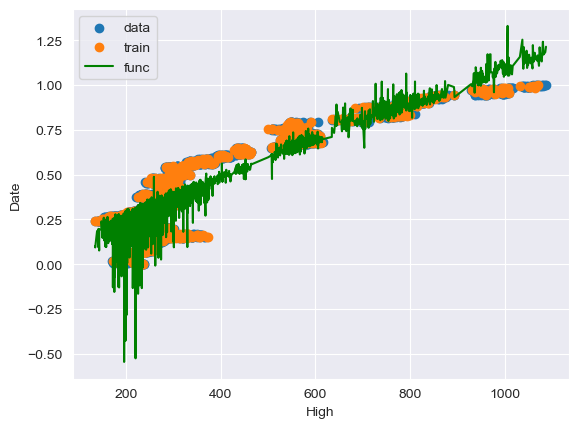

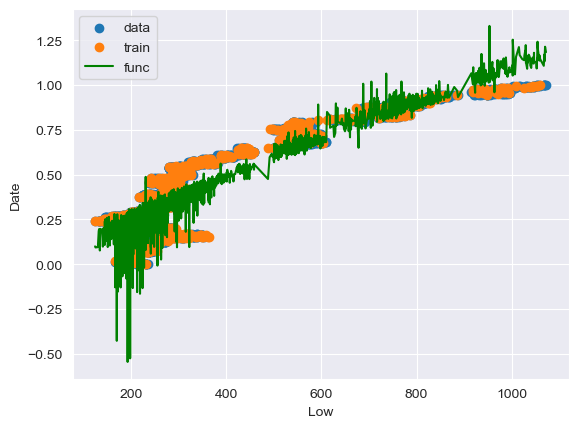

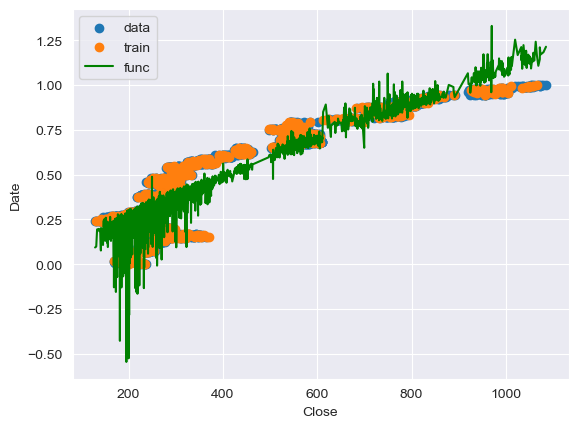

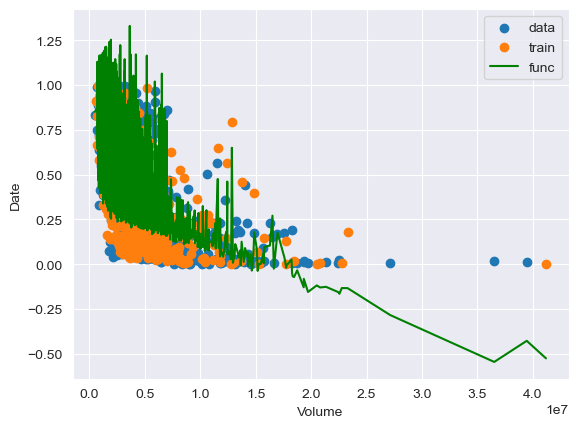

In [35]:
for i in range(len(columns)):
    # x_new = np.linspace(mnk.x.min(), mnk.x.max(), num=500,
    #                     endpoint=True)  # np.arange(x.min(), x.max(), (x.max() - x.min()) / 100)
    data = df.sort_values(by=columns[i])
    plt.scatter(df[columns[i]][indexes], df[predict_column][indexes], label='data')
    plt.scatter(sample[columns[i]], sample[predict_column], label='train')
    plt.plot(data[columns[i]], ridge.predict(data.loc[:, columns[~columns.isin([predict_column])]].to_numpy()), label='func',
             color='green')
    plt.legend(loc='best')
    plt.ylabel(predict_column)
    plt.xlabel(columns[i])
    ax = plt.gca()
    # ax.set_xlim([0, 1])
    # ax.set_ylim([0, 1])
    # pprint(mnk.c)
    plt.show()

exp_data = ridge.predict(df.loc[:, columns[~columns.isin([predict_column])]].to_numpy())
exp_data = exp_data.reshape(len(exp_data))

In [36]:
sns.boxenplot(data=pd.DataFrame({"Predict":mnk(df.loc[:, columns[~columns.isin([predict_column])]].to_numpy().T).T, "data": df[predict_column].values.T}))

<AxesSubplot:>

In [37]:
print(f"Стьюдент {stats.ttest_ind(exp_data, df[predict_column])}")
stat = f_test(exp_data, df[predict_column])
print(f"F-test   stat = {stat[0]}, pvalue = {stat[1]}")
stat = stats.chi2_contingency([np.abs(exp_data), np.abs(df[predict_column])])
print(f"X2       stat = {stat[0]}, pvalue = {stat[1]}")

Стьюдент Ttest_indResult(statistic=-0.5197966549120783, pvalue=0.603224372278224)
F-test   stat = 0.8852950262604553, pvalue = 0.9995889639351676
X2       stat = 64.06543442418075, pvalue = 1.0
